# Magyar NLP - elemzések I.

**Tartalom:**
* Csomagbeolvasás
* Fájlok beolvasása
* Névelem felismerés (Named Entity Recognition)
* Top szavak vizualizációja
* Topic Modeling
* Sentiment Analysis

In [1]:
# adatkezelés
import pandas as pd
import numpy as np

# NLP csomagok:
import spacy
import hu_core_ud_lg as hu
nlp = hu.load()


from collections import Counter
%matplotlib inline




C:\Users\molna\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'hu_core_ud_lg' (0.3.1) requires spaCy v2.1 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [111]:
df = pd.read_pickle('2020_nlp_preprocessed')

print("A korpusz elemszáma: {}".format(len(df)))

A korpusz elemszáma: 3851


In [112]:
df.columns

Index(['cim', 'datum', 'szerzo', 'tag', 'merged', 'cim_word_cnt',
       'cim_avg_word', 'szoveg_num_exclam', 'szoveg_num_ques', 'cim_stop_cnt',
       'cim_cnt_upper', 'merged_cleaned', 'merged_cleaned_tokens',
       'merged_cleaned_lemmas', 'merged_cleaned_ners'],
      dtype='object')

In [113]:
df.head(2)

,cim,datum,szerzo,tag,merged,cim_word_cnt,cim_avg_word,szoveg_num_exclam,szoveg_num_ques,cim_stop_cnt,cim_cnt_upper,merged_cleaned,merged_cleaned_tokens,merged_cleaned_lemmas,merged_cleaned_ners
"""4081""",Hadházy összekalapozott kétmillió forintot a b...,"""2020.02.20. 20:50 ""","""NA""","""Belföld,hadházy,ákos,büntetés,bírság,parlamen...",Hadházy Ákos független országgyűlési képvisel...,6,8.5,1,0,1,0,hadházy ákos független országgyűlési képviselő...,"[hadházy, ákos, független, országgyűlési, képv...","[hadházy, ákos, független, országgyűlési, képv...","[NOUN, ADJ, ADJ, ADJ, NOUN, ADV, ADJ, NOUN, AD..."
"""7384""",Alaposan megfogyatkoztak a turisták Budapesten,"""2020.03.14. 17:12""","""NA""","""Belföld,kínai,koronavírus,koronavírus,magyaro...",Az új koronavírus okozt járvány pandémiává te...,5,8.4,1,1,1,0,koronavírus okozt járvány pandémiává terebélye...,"[koronavírus, okozt, járvány, pandémiává, tere...","[koronavírus, okozt, járvány, pandémia, terebé...","[NOUN, ADJ, NOUN, NOUN, NOUN, DET, NOUN, ADJ, ..."


### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Névelem felismerés
A NER segítségével kinyerhetők egy adott korpuszon belül előforduló névelemek, ezen belül is
tulajdonnevek, mint például a személynevek, földrajzi helyek, szervezetek.

**Névelemek kigyűjtése dokumentumonként**

In [114]:
dic = {}
lis = []
for i in df['merged']:
    token = []
    entit = []
    doc = nlp(i)
    for ent in doc.ents:
        token.append(ent.text)
        entit.append(ent.label_)
    dic = dict(zip(token, entit))
    lis.append(dic)

Minden egyes dokumentumra létrehozunk egy szótárat (kulcs, érték pár). A Spacy a megtalált entitásokhoz hozzárendeli a névelemet.
<br>
<br>
A névelemek listája a python_HUN_NLP_bevez_I notebook-ban található.

In [115]:
lis[0]

{'Hadházy Ákos': 'PER',
 'ATV': 'ORG',
 'Egyenes Beszéd': 'MISC',
 'Fotó:': 'ORG',
 'Kövér László': 'PER',
 'Országgyűlés': 'ORG',
 'Stop propaganda!': 'MISC',
 '” felirattal': 'MISC',
 'Hadházy': 'PER',
 'Parlamentet': 'ORG',
 '”.': 'MISC',
 'Kövér Lászlónak': 'PER'}

Az első dokumentumból, a szótáron való végigiterálással lehet kigyűjteni a különböző típusú névelemeket.

In [116]:
{key:value for (key, value) in lis[900].items() if value == 'PER'}

{'Rodri Hernández': 'PER', 'Kevin De Bruyne': 'PER'}

**Személynevek lista létrehozása dokumentumonként**

In [117]:
per_list = []
for i in range(0, len(lis)):
    per_ent = {key:value for (key, value) in lis[i].items() if value == 'PER'}
    per_ent = list(per_ent.keys())
    
    per_list.append(per_ent)

In [118]:
per_list[0]

['Hadházy Ákos', 'Kövér László', 'Hadházy', 'Kövér Lászlónak']

**Személynevek lista hozzárendelése a dokumentumgyűjteményhez**
<br>
<br>
**!** Egy listát hozzáfűzhetünk a DataFrame-hez oszlopként

In [119]:
df['persons'] = per_list

**!** A per_list objektum egy "list of lists", mivel dokumentumonként állítottuk elő a listákat. A top N db előállításához a listát "laposítanunk" kell, azaz vissza kell alakítanunk listává.

In [120]:
flat_person_list = [ item for elem in per_list for item in elem]

**Top 10 leggyakrabban előforduló személynév a dokumentumgyűjteményben**

In [121]:
per_counts = Counter(flat_person_list).most_common(15)

In [122]:
df_top_pers = pd.DataFrame(per_counts, columns =['person', 'count'])
df_top_pers

,person,count
0,Orbán Viktor,150
1,Donald Trump,132
2,Thomas Bach,85
3,Müller Cecília,82
4,Trump,70
5,Huszti István,69
6,Lakatos Tibor,69
7,Van,66
8,Orbán,66
9,Karácsony Gergely,64


A Névelem felismerést a szövegen kell végrehajtani, az entitásokat itt tudja értelmezni az algoritmus, így sajnos többféleképp bekerülhetnek a névelemek a listánkba. Ezeket így tudjuk átnevezni, majd újra szummázni.

In [123]:
df_top_pers['person'].replace({'Trump': 'Donald Trump', 'Orbán': 'Orbán Viktor', 
                              'Justin Trudeau-val': 'Justin Trudeau'}, inplace = True)

In [124]:
df_top_pers = df_top_pers[~df_top_pers['person'].isin(['Van', 'Vannak'])]

In [125]:
df_top_pers = df_top_pers.groupby(['person'])['count'].agg('sum').reset_index().sort_values(by=['count'],
                                                                                           ascending = False)

In [126]:
df_top_pers

,person,count
9,Orbán Viktor,216
0,Donald Trump,202
10,Thomas Bach,85
8,Müller Cecília,82
3,Huszti István,69
7,Lakatos Tibor,69
6,Karácsony Gergely,64
4,Idris Elbával,54
5,Justin Trudeau,54
2,Hamilton,53


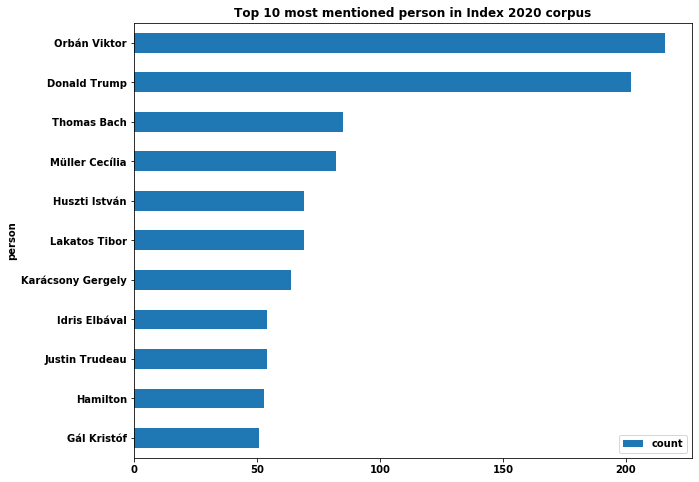

In [127]:
df_top_pers.plot.barh(x='person',
                      y='count',
                      title="Top 10 most mentioned person in Index 2020 corpus",
                      figsize=(10,8)).invert_yaxis()

**!! FELADAT:** Hozzd létre a földrajzi helyekre, vagy a szervezetekre a listát, majd vizualizáld a top 10-et oszlopdiagramon.

**Kitérés**: Innentől lehetőségünk Névelem alapú szűrésre is.

In [130]:
nevek = ['Orbán Viktor', 'Orbán']

In [131]:
df['orban_flg'] = df["persons"].apply(lambda x: 1 if any(i in x for i in nevek) else 0)

In [133]:
df_orban = df[df['orban_flg'] == 1]

In [134]:
df_orban.head(2)

,cim,datum,szerzo,tag,merged,cim_word_cnt,cim_avg_word,szoveg_num_exclam,szoveg_num_ques,cim_stop_cnt,cim_cnt_upper,merged_cleaned,merged_cleaned_tokens,merged_cleaned_lemmas,merged_cleaned_ners,persons,orban_flg
"""4447""",Újabb fordulat a Természettudományi Múzeumban:...,"""2020.02.24. 09:11""","""NA""","""Tech-Tudomány,természettudományi,múzeum,ember...","Forrásaink arról tájékoztatták az Indexet, ho...",8,9.0,1,1,1,0,forrásaink tájékoztatták indexet természettudo...,"[forrásaink, tájékoztatták, indexet, természet...","[forrás, tájékoztat, index, természettudományi...","[NOUN, VERB, NOUN, ADJ, NOUN, NOUN, DET, NOUN,...","[Forrásaink, Matskási István, Orbán Viktor, Be...",1
"""7145""",Újabb három magyar koronavírus-fertőzött van,"""2020.03.13. 10:05""","""NA""","""Belföld,koronavírus,magyarországon,magyarorsz...",19-re nőtt a Magyarországon diagnosztizált új...,5,8.0,1,1,2,0,re nőtt magyarországon diagnosztizált koronaví...,"[re, nőtt, magyarországon, diagnosztizált, kor...","[re, nő, magyarország, diagnosztizált, koronav...","[NOUN, VERB, ADJ, ADJ, NOUN, NOUN, NOUN, VERB,...","[Orbán Viktor, Szent László, Szent János, Ajpe...",1


**!! FELADAT:** Hozzd létre egy szűrt DataFrame-et, amelyben Müller Cecillia, mint PER névelem szerepel.

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## CBOW modell (szóbeágyazási modellek)

A tokenizáció révén olyan listákat kapunk, amelyben a szavak egymástól vett távolsága értelmezhető lesz. A szóbeágyazási modellek ezt a távolságot veszik figyelembe. A tokeneket úgynevezett N-grammként kezelik ezek a modellek. Az N-grammokkal minden egyes szóhoz hozzá tudjuk rendelni N távolságnyi környezetét. 
<br>
A szó minden egyes előfordulása során megkapjuk azt, hogy a környezetében milyen más szavakkal együtt fordult elő, és melyikkel milyen gyakran.
<br>
A CBOW modell megkeresi a keresőszóhoz közeli szavakat (milyen más szavakkal fordul elő a szövegben).
<br>
<br>
**? Mire használható?**
<br>
* Például kulcsszólista összeállítására (mik azok a szavak az SZFE-hez állnak közel/távol? )
* Megváltoznak-e azok a szavak, amelyek az szfe-hez vagy a tüntetésekhez köthetőek? (időben vagy eseményhez köthetően)

In [135]:
from gensim.models import Word2Vec

In [136]:
CBOW_model = Word2Vec(df["merged_cleaned_lemmas"], min_count=5, workers=3, window=9, sg=0)

In [151]:
CBOW_model.most_similar(positive= ['koronavírus'], negative=[], topn=10, restrict_vocab=None, indexer=None)

C:\Users\molna\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('terjedés', 0.8563487529754639),
 ('gócpont', 0.8419327139854431),
 ('olaszországi', 0.8364930152893066),
 ('olaszország', 0.8337892293930054),
 ('góc', 0.8334008455276489),
 ('vuhan', 0.8324505090713501),
 ('járvány', 0.8319606781005859),
 ('nélkülözhető', 0.8319025635719299),
 ('megbetegedett', 0.8274290561676025),
 ('lombardia', 0.8256130218505859)]

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Top N szó vizualizációja

In [143]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer # creating document term matrix

In [144]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [145]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(df["merged_cleaned_lemmas"].astype(str))

In [146]:
count_data

<3851x86270 sparse matrix of type '<class 'numpy.int64'>'
	with 667454 stored elements in Compressed Sparse Row format>

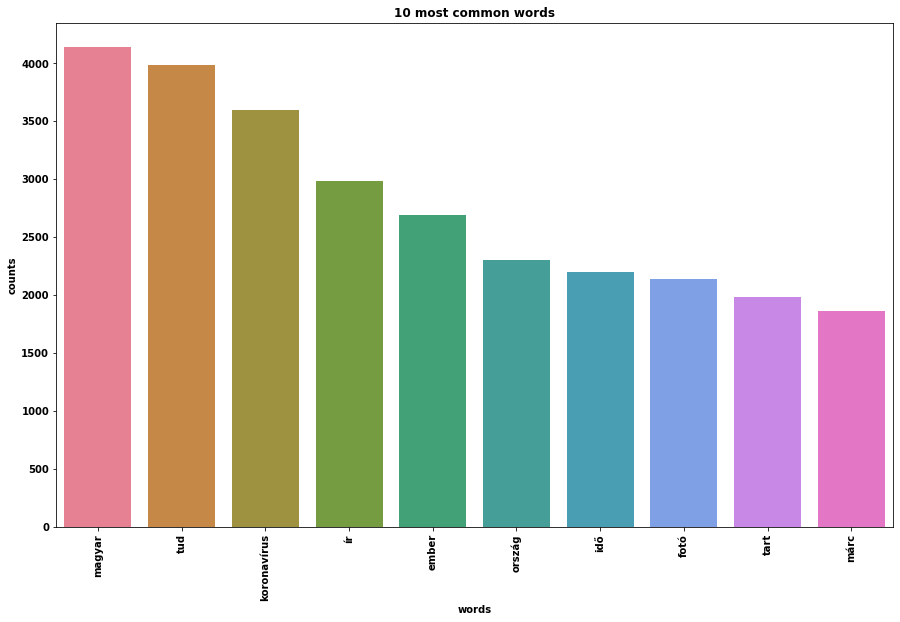

In [147]:
plot_10_most_common_words(count_data, count_vectorizer)

### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Topic Modeling (Latent Dirichlet Allocation)

A Topic Modelling olyan technika amely segítségével az olykor hatalmas dokumentumgyűjteményben a rejtett témák feltárhatók. A Látens Direchlet Allokáció (LDA) a topik modellezéshez használható eljárás.
<br>
<br>
Az LDA során az a célunk, hogy a dokumentumgyűjteményből jól elkülöníthető, jelentésteljes témákat kapjunk. Az LDA egy olyan nem felügyelt gépi tanulási eljárás, amely a dokumentumokhoz topikszavakat rendel. A topikszavak a különböző dokumentumokban értelmezett gyakoriságuk alapján keletkeznek. Tehát egyes szavak gyakrabban bukkannak fel adott témát illetően, mint egy másik topikban, amiben szintén vannak egyéb csoportra jellemző szavak. Az LDA így az alapján kategorizál, hogy az egy témába tartozó dokumentumoknak hasonló a szókészlete. 
<br>
<br>
Ez alapvetően két tényezőtől függ: az előfeldolgozás minőségén és a modell hiperparamétereinek helyes beállításán (pl.: number_of_components (topics).
<br>
Segítségével meghatározható, például hogy egy évben mik voltak a legmeghatározóbb témák, amelyről egy portál írt.

### LDA - Sklearn
Dokumentáció: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [152]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [153]:
def print_topics(model, count_vectorizer, n_top_words):
    """
    Helper függvény.
    Kiírja a topikokba tartozó N db kulcsszót.
    """
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [155]:
# LDA modellünk paraméterezése:
lda = LDA(n_components=5, n_jobs=-1)

# modell fitting-je
lda.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [156]:
# Írjuk ki a topikokat és a kulcsszavaikat, amelyeket talált a modellünk
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 20)

Topics found via LDA:

Topic #0:
csapat meccs px gól perc es heigh játékos film font tud játszik bajnokság mérkőzés szezon nyer pont labda hely pálya

Topic #1:
magyar tud ír férfi ügy ember tart forint tesz csoport index fotó cég ami vesz nő rész kap kormány idő

Topic #2:
th film hungary című hungari coronavirus government ha ami index bu wer people firs orbán budapest jó new sorozat műsor

Topic #3:
koronavírus márc járvány ország tud ember vírus akta magyar kínai világ fertőzött beteg egészségügyi szám nap idő ír fertőzés eset

Topic #4:
amerikai állam elnök százalék fotó trump ország tud magyar ír rész vezető iráni európai kormány egyesült fog eu ami idő


In [158]:
topic_values = lda.transform(count_data)

In [160]:
df['topic_lda'] = topic_values.argmax(axis=1)

In [163]:
print("Topic 0-ba tartozó dokumentumok száma: {}".format(len(df[df['topic_lda'] == 0])))
print("Topic 1-ba tartozó dokumentumok száma: {}".format(len(df[df['topic_lda'] == 1])))
print("Topic 2-ba tartozó dokumentumok száma: {}".format(len(df[df['topic_lda'] == 2])))
print("Topic 3-ba tartozó dokumentumok száma: {}".format(len(df[df['topic_lda'] == 3])))
print("Topic 4-ba tartozó dokumentumok száma: {}".format(len(df[df['topic_lda'] == 4])))

Topic 0-ba tartozó dokumentumok száma: 432
Topic 1-ba tartozó dokumentumok száma: 1567
Topic 2-ba tartozó dokumentumok száma: 136
Topic 3-ba tartozó dokumentumok száma: 1079
Topic 4-ba tartozó dokumentumok száma: 637


### LDA - Gensim 

In [164]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


**Szótár létrehozása**

In [165]:
id2word = corpora.Dictionary(df["merged_cleaned_lemmas"])
id2word.filter_extremes(no_above=0.1, no_below=10)

**Term Document Frequency**

In [167]:
corpus = [id2word.doc2bow(text) for text in df["merged_cleaned_lemmas"]]

In [168]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 2), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 2), (41, 1)]]


A gensim minden szótárban szereplő szóhoz készít egy egyedi id-t. A corpus pedig a dokumentumban fellelhető egyedi szavak mellé előfordulási gyakoriságot rendel. Tehát a (0, 1) azt jelenti, hogy a 0-ás ID-jú szó 1x szerepelt az első dokumentumban.

In [169]:
id2word[3]

'beszéd'

**LDA modell építése**

In [170]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Topikok kiírása az LDA modellből**
<br>
<br>
Az LDA modell 5 topikkal tért vissza. A topikokat az abban szereplő kulcsszavak határozzák meg (innen lehet rájönni, hogy melyik melyik téma) és minden kulcsszóhoz rendel egy súlyt a modell.
<br>
Például a 4. téma így jön létre: '0.012*"koronavírus" + 0.007*"ország" + 0.006*"járvány" + 0.006*"szám" + 0.006*"magyar" + 0.005*"márc" + 0.005*"mti" + 0.005*"ember" + 0.005*"világ" + 0.005*"március"
<br>
Ami azt jelenti, hogy a top 10 kulcsszó a 4. topicban: koronavírus, ország, járvány, szám, magyar, márc, mti, ember, világ, március. A súly pedig azt jelenti, hogy egy szó mennyire fontos egy témán belül.

In [171]:
print(lda_model.print_topics())

[(0, '0.008*"film" + 0.005*"lászló" + 0.005*"című" + 0.005*"gyerek" + 0.004*"helyszín" + 0.004*"kép" + 0.004*"polgármester" + 0.004*"vizsga" + 0.004*"gondol" + 0.004*"működik"'), (1, '0.005*"milliárd" + 0.005*"rendszer" + 0.005*"g" + 0.005*"probléma" + 0.004*"részben" + 0.004*"időszak" + 0.004*"állami" + 0.004*"hatás" + 0.004*"dollár" + 0.003*"program"'), (2, '0.007*"koronavírusos" + 0.007*"törzs" + 0.007*"karantén" + 0.007*"állampolgár" + 0.006*"operatív" + 0.006*"iráni" + 0.006*"kína" + 0.006*"olaszország" + 0.006*"orvos" + 0.006*"trump"'), (3, '0.020*"the" + 0.020*"th" + 0.014*"of" + 0.012*"játékos" + 0.011*"gól" + 0.010*"meccs" + 0.010*"in" + 0.010*"to" + 0.009*"and" + 0.009*"all"'), (4, '0.013*"vád" + 0.008*"képviselő" + 0.008*"eljárás" + 0.007*"visszautasít" + 0.006*"bíróság" + 0.006*"politikai" + 0.005*"tamás" + 0.005*"brit" + 0.005*"eu" + 0.005*"ar"')]


**Modell kiértékelése**
<br>
A modell jóságának mérőszáma a koherencia lehet.
<br>
0 és 1 közötti mutató, minél közelebb van 1-hez, annál koherensebbek a topikok.

In [172]:
# Coherence Score kiszámítása
coherence_model_lda = CoherenceModel(model=lda_model, texts=df["merged_cleaned_lemmas"], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4324720313401829


**Vizualizáció**

In [173]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.112069 -0.108177       1        1  27.403566
0      0.156736 -0.029975       2        1  27.154991
4      0.047017  0.369191       3        1  15.892783
2      0.083102 -0.192322       4        1  15.572804
3     -0.398924 -0.038718       5        1  13.975853, topic_info=            Term         Freq        Total Category  logprob  loglift
964          the  1638.000000  1638.000000  Default  30.0000  30.0000
817           th  1616.000000  1616.000000  Default  29.0000  29.0000
3018          of  1183.000000  1183.000000  Default  28.0000  28.0000
1782         vád  1183.000000  1183.000000  Default  27.0000  27.0000
1444     játékos   988.000000   988.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1943        mlsz   374.487762   376.642609   Topic5  -5.3880   1.9621
1405  válogatott   731.658752   804.379211   Topic5  -4.7182   1.8731
126           at   331.098389   342.649017   Topic5  -5.5111   1.9335
2910   szövetség   521.395203   810.138794   Topic5  -5.0570   1.5271
1807           f   340.346985   474.720886   Topic5  -5.4835   1.6351

[230 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4277      3  0.997203    alaptalan
42        1  0.998668         alig
5010      5  0.998209          all
2389      5  0.999553          and
1209      2  0.002325           ar
...     ...       ...          ...
1166      1  0.998709       állami
2492      4  0.998105  állampolgár
984       1  0.998877           ár
1516      3  0.997671       épület
1577      4  0.997283       érkező

[262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

**Dashboard értelmezése**
<br>
A bal oldali vizualizácion a buborékok egy topikot reprezentálnak. A buborék mérete, azt jelenti, hogy a dokumentumok mekkora része esett a topikba. Minél nagyobb, annál több dokumentumot foglal magába.
<br>
A vizualizáció is árulkodhat a modell jóságáról. Nem jó ha kis buborékaink vannak, és nem jó az ha átfedik egymást. Esetünkben az 1-es és a 2-es topikok nagy átfedésben vannak. Az a jó ha a topikok között nagy a távolság (~klaszterezés).
<br>
<br>
A bal oldali oszlopdiagram pedig az egyes topikokon belüli top 30 kulcsszót jeleníti meg.

In [175]:
corpus_lda = lda_model[corpus]

In [179]:
corpus_lda[0][0]

[(0, 0.42203066), (1, 0.120918825), (2, 0.032495316), (4, 0.4171081)]

**Melyik téma a legdominánsabb az egyes dokumentumok esetében?**
<br>
<br>
Az LDA modellek során mindegyik dokumentum több témához is hozzá lesz rendelve, de csak egy téma lesz domináns.
<br>
Az alábbi kód minden dokumentumhoz csak a legmeghatározottabb témát rendeli hozzá. Majd a téma számát hozzáfűzzük az eredeti dokumentumgyűjteményünkhüz.

In [177]:
sent_topics_df = pd.DataFrame()

# Get main topic in each document
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    #print(row)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']


In [178]:
sent_topics_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0.0,0.4220,"film, lászló, című, gyerek, helyszín, kép, pol..."
1,1.0,0.3998,"milliárd, rendszer, g, probléma, részben, idős..."
2,0.0,0.6528,"film, lászló, című, gyerek, helyszín, kép, pol..."
3,1.0,0.5388,"milliárd, rendszer, g, probléma, részben, idős..."
4,1.0,0.5989,"milliárd, rendszer, g, probléma, részben, idős..."
...,...,...,...
3846,1.0,0.6073,"milliárd, rendszer, g, probléma, részben, idős..."
3847,1.0,0.4949,"milliárd, rendszer, g, probléma, részben, idős..."
3848,0.0,0.4180,"film, lászló, című, gyerek, helyszín, kép, pol..."
3849,1.0,0.5116,"milliárd, rendszer, g, probléma, részben, idős..."


In [180]:
df['topic'] = list(sent_topics_df['Dominant_Topic'])

In [181]:
df['topic_perc'] = list(sent_topics_df['Perc_Contribution'])

In [184]:
print("Topic 0-ba tartozó dokumentumok száma: {}".format(len(df_1[df_1['topic'] == 0])))
print("Topic 1-ba tartozó dokumentumok száma: {}".format(len(df_1[df_1['topic'] == 1])))
print("Topic 2-ba tartozó dokumentumok száma: {}".format(len(df_1[df_1['topic'] == 2])))
print("Topic 3-ba tartozó dokumentumok száma: {}".format(len(df_1[df_1['topic'] == 3])))
print("Topic 4-ba tartozó dokumentumok száma: {}".format(len(df_1[df_1['topic'] == 4])))

Topic 0-ba tartozó dokumentumok száma: 1095
Topic 1-ba tartozó dokumentumok száma: 1003
Topic 2-ba tartozó dokumentumok száma: 703
Topic 3-ba tartozó dokumentumok száma: 572
Topic 4-ba tartozó dokumentumok száma: 478


**Vizualizáció matplotlib-bel**

In [100]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df["merged_cleaned_lemmas"] for w in w_list]

counter = Counter(data_flat)

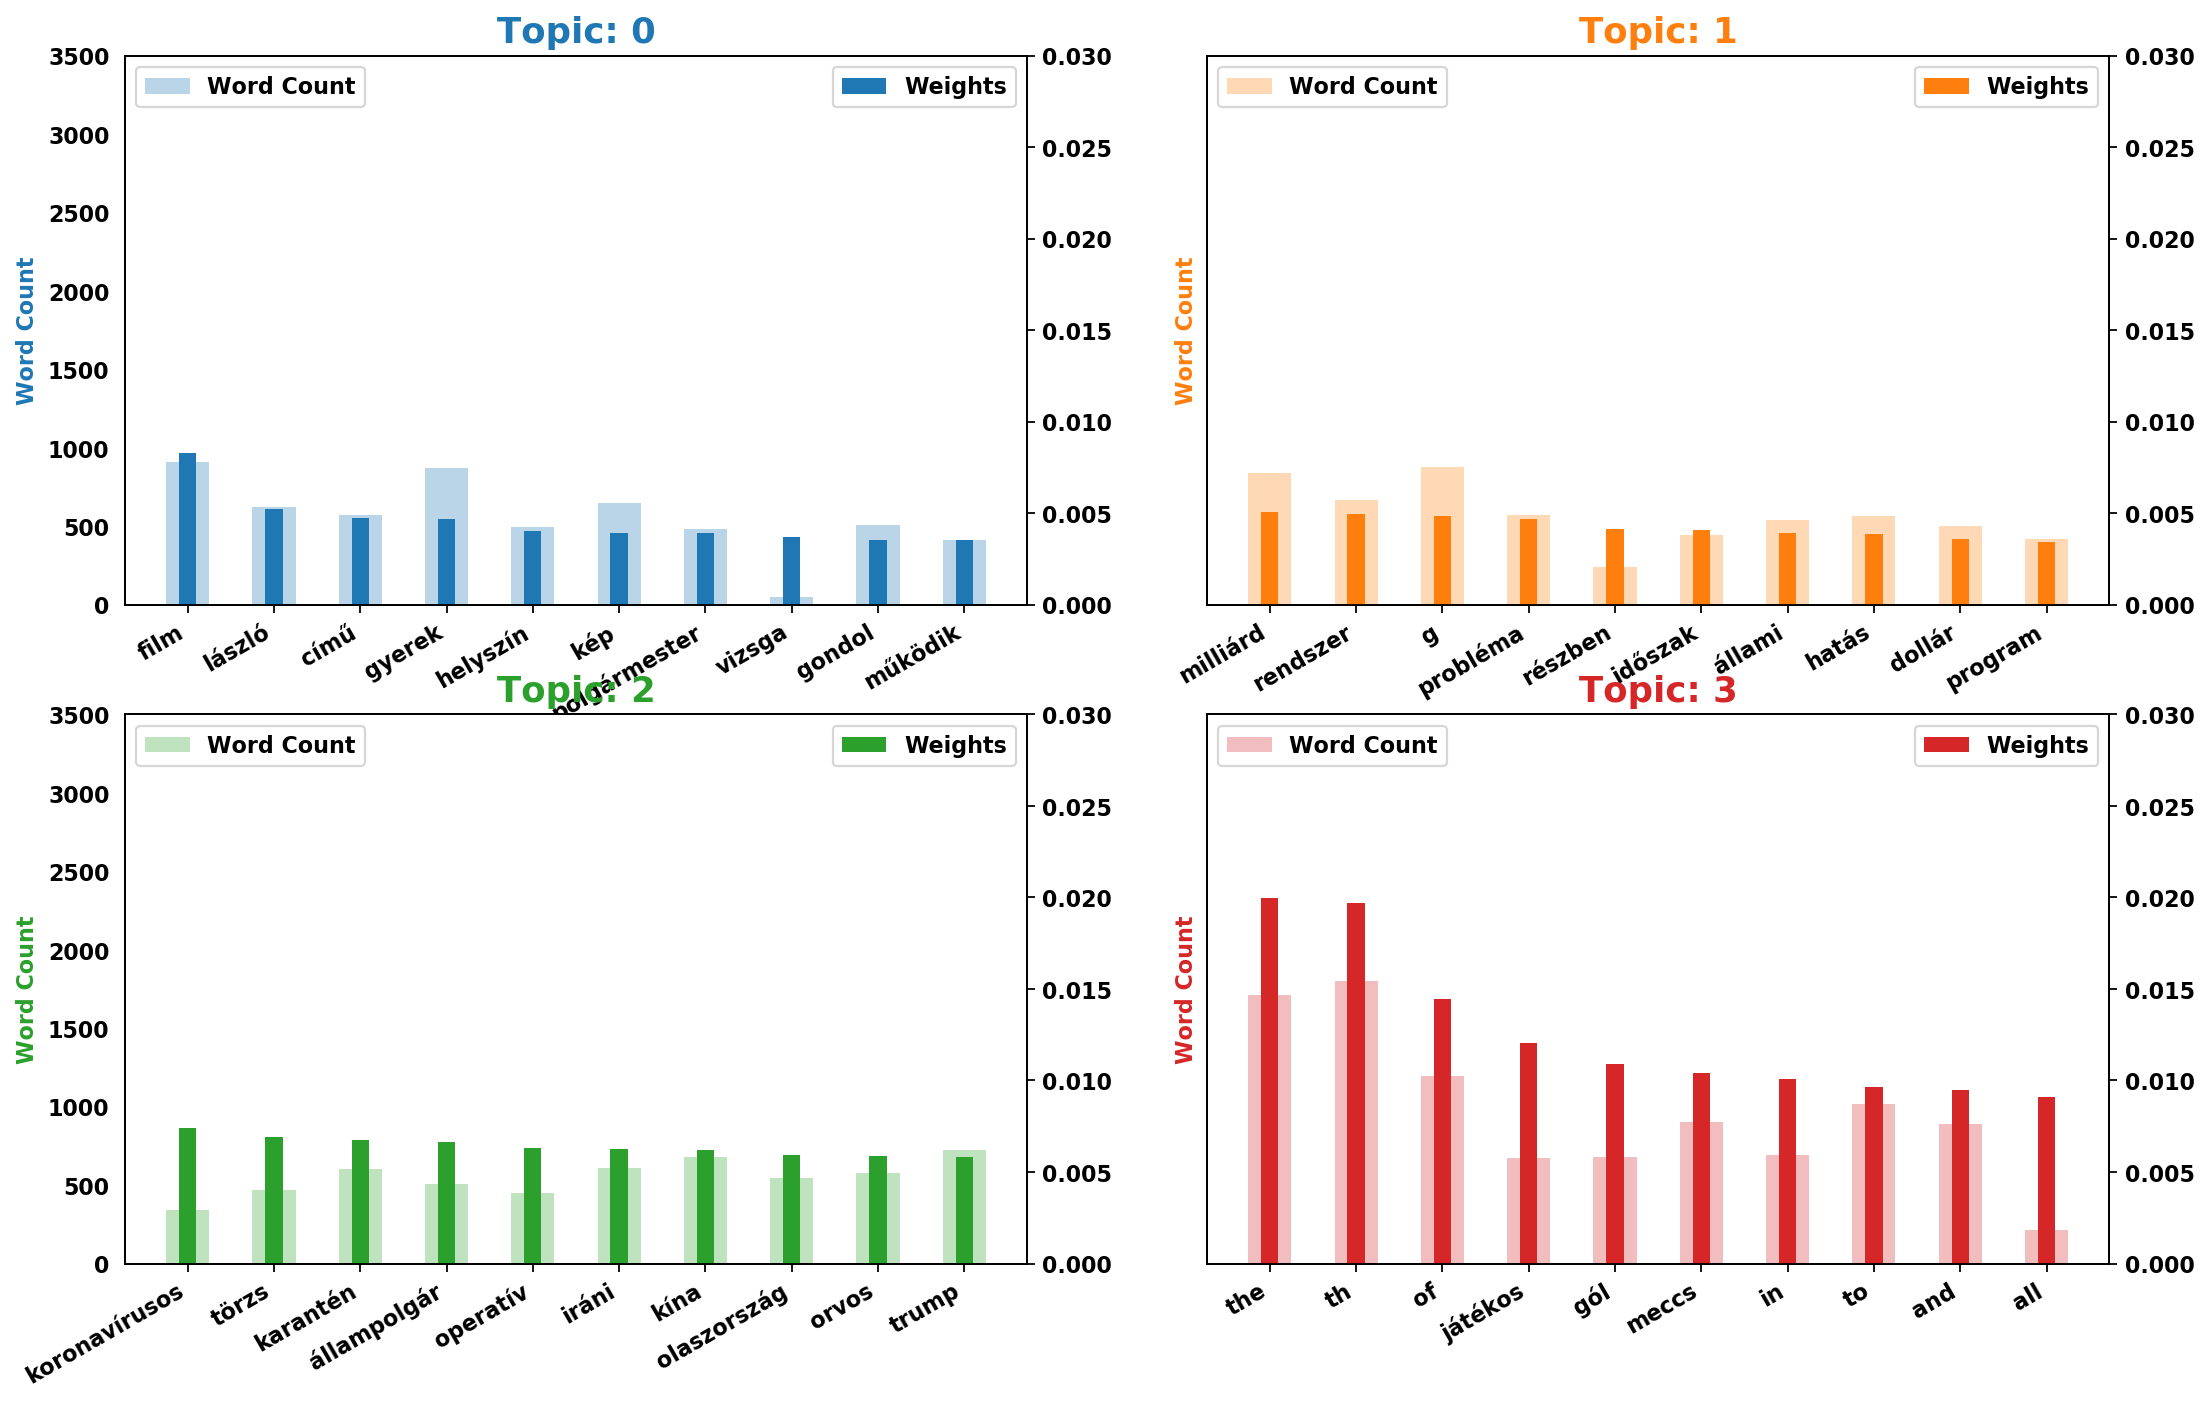

In [103]:
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')



### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


## Szentiment analitika

In [187]:
with open("nlp_utils/neg.txt", "r", encoding='utf-8') as f:
    neg = [i for line in f for i in line.split('\n')]
    neg = list(filter(None, neg))

In [190]:
neg[0:10]

['abajgat',
 'abajgós',
 'abajog',
 'aberrált',
 'abnormális',
 'abszurd',
 'abszurditás',
 'abszurdum',
 'ácsingózik',
 'ádáz']

In [191]:
with open("nlp_utils/pos.txt", "r", encoding='utf-8') as f:
    pos = [i for line in f for i in line.split('\n')]
    pos = list(filter(None, pos))
    
pos[1:10]

['adakozó',
 'adottság',
 'aduász',
 'affinitás',
 'agilis',
 'agilitás',
 'agyas',
 'ahítat',
 'áhitat']

In [193]:
df_korona = pd.read_pickle('2020_korona_corpus')

In [199]:
df_korona.head(2)

,cim,datum,szerzo,tag,merged,cim_word_cnt,cim_avg_word,szoveg_num_exclam,szoveg_num_ques,cim_stop_cnt,cim_cnt_upper,merged_cleaned,merged_cleaned_tokens,merged_cleaned_lemmas,merged_cleaned_ners,korona_flg
"""7384""",Alaposan megfogyatkoztak a turisták Budapesten,"""2020.03.14. 17:12""","""NA""","""Belföld,kínai,koronavírus,koronavírus,magyaro...",Az új koronavírus okozt járvány pandémiává te...,5,8.40,1,1,1,0,koronavírus okozt járvány pandémiává terebélye...,"[koronavírus, okozt, járvány, pandémiává, tere...","[koronavírus, okozt, járvány, pandémia, terebé...","[NOUN, ADJ, NOUN, NOUN, NOUN, DET, NOUN, ADJ, ...",1
"""6669""",Több ezer maszkot loptak el egy kórházból Íror...,"""2020.03.10. 15:55""","""NA""","""Külföld,kínai,koronavírus,koronavírus,írorszá...",Több ezer egészségügyi maszkot loptak el egy ...,8,5.75,0,0,3,0,egészségügyi maszkot loptak rákbetegekre speci...,"[egészségügyi, maszkot, loptak, rákbetegekre, ...","[egészségügyi, maszk, lop, rákbeteg, specializ...","[ADJ, NOUN, VERB, ADJ, ADJ, NOUN, VERB, ADJ, N...",1


In [216]:
df_korona["datum"] = df_korona["datum"].str.replace('"', '')

In [219]:
df_korona["datum"] = df_korona['datum'].apply(lambda x: x[0:10])

In [223]:
df_korona["datum"] = df_korona["datum"].str.replace('.', '-')

In [225]:
df_korona[df_korona["datum"] > '2020-03-10'].head(1)

,cim,datum,szerzo,tag,merged,cim_word_cnt,cim_avg_word,szoveg_num_exclam,szoveg_num_ques,cim_stop_cnt,cim_cnt_upper,merged_cleaned,merged_cleaned_tokens,merged_cleaned_lemmas,merged_cleaned_ners,korona_flg,senti,senti_pol
"""7384""",Alaposan megfogyatkoztak a turisták Budapesten,2020-03-14,"""NA""","""Belföld,kínai,koronavírus,koronavírus,magyaro...",Az új koronavírus okozt járvány pandémiává te...,5,8.4,1,1,1,0,koronavírus okozt járvány pandémiává terebélye...,"[koronavírus, okozt, járvány, pandémiává, tere...","[koronavírus, okozt, járvány, pandémia, terebé...","[NOUN, ADJ, NOUN, NOUN, NOUN, DET, NOUN, ADJ, ...",1,"[0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, -1, 0,...",-0.04


## Polaritásvizsgálat

**Polarizáló függvény**: A polarizáló függvény végigiterál a dokumentum lemmáin és ha a lemma a negatív szótárban szerepel, akkor -1-et, ha a pozitívban akkor 1-et rendel hozzá. Ha az egyik listában sem szerepel, akkor neutrálisnak véljük a lemmát és 0-ás értéket kap.

In [194]:
def sentiment_polarizer(df):
    sent = []
    for i in range(0, len(df)):
        if str(df[i]) in pos: 
            sent.append(1)
        elif str(df[i]) in neg: 
            sent.append(-1)
        else:
            sent.append(0)
    return sent

**Gyors példa**:

In [203]:
text = ['akadozó', 'szallitmany', 'miatt', 'halt', 'szörnyű', 'halálos', 'baleset', 'járvány', 'pandémia', 'lop']
sentiment_polarizer(text)

[-1, 0, 0, 0, -1, -1, -1, -1, 0, -1, 0]

**Függvény meghívása a lemmákra dokumentumonként**

In [204]:
df_korona['senti'] = df_korona['merged_cleaned_lemmas'].apply(lambda x: sentiment_polarizer(x))

In [206]:
df_korona['senti']

"7384"    [0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, -1, -1, 0,...
"6669"    [0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
"8438"    [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"5067"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"4443"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0,...
                                ...                        
"3939"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,...
"7994"    [0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0...
"8184"    [0, 0, 0, 0, 0, 0, -1, 0, -1, -1, 0, 0, 0, 0, ...
"3054"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"8291"    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
Name: senti, Length: 1012, dtype: object

In [207]:
def polariser(lista):
    atlagok = sum(lista) / len(lista)
    return atlagok

In [210]:
df_korona['senti_pol'] = df_korona['senti'].apply(lambda x: polariser(x))
df_korona[['cim', 'senti_pol']].head(3)

,cim,senti_pol
"""7384""",Alaposan megfogyatkoztak a turisták Budapesten,-0.040000
"""6669""",Több ezer maszkot loptak el egy kórházból Íror...,-0.068493
"""8438""",Túlélőtippek Bear Gryllstől a bezártság átvész...,0.000000


**Megjegyzés**: itt is érdemes lehet az adathalmazt kettéválasztani pozitív és negatív polarítású cikkekre és CBOW-al megnézni, hogy a 2 halamaz mentén milyen szövegkörnyezete van a tüntetés/ szfe szónak!!!!

## Szubjektivitásvizsgálat

**Szubjektivitás függvény**: A szubjektivitás függvény végigiterál a dokumentum lemmáin és ha a lemma a negatív vagy a pozitív szótárban szerepel, akkor 1-et, ha az egyik listában sem szerepel, akkor neutrálisnak véljük a lemmát és 0-ás értéket kap.

In [226]:
def subjectivity(df):
    sent = []
    for i in range(0, len(df)):
        if str(df[i]) in pos: 
            sent.append(1)
        elif str(df[i]) in neg: 
            sent.append(1)
        else:
            sent.append(0)
    return sent

In [227]:
df_korona['subj'] = df_korona['merged_cleaned_lemmas'].apply(lambda x: subjectivity(x))

In [228]:
df_korona['subj']

"7384"    [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...
"6669"    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"8438"    [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"5067"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"4443"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
                                ...                        
"3939"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
"7994"    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
"8184"    [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...
"3054"    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
"8291"    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
Name: subj, Length: 1012, dtype: object

In [229]:
df_korona['subj_mean'] = df_korona['subj'].apply(lambda x: np.mean(x))
df_korona['subj_mean']

"7384"    0.120000
"6669"    0.123288
"8438"    0.102941
"5067"    0.118012
"4443"    0.100629
            ...   
"3939"    0.084337
"7994"    0.096579
"8184"    0.061508
"3054"    0.017964
"8291"    0.142322
Name: subj_mean, Length: 1012, dtype: float64

In [231]:
subjectivitas = df_korona.groupby(['datum'], as_index=False)['subj_mean'].mean()
subjectivitas

,datum,subj_mean
0,2020-01-02,0.188776
1,2020-01-03,0.103704
2,2020-01-04,0.069853
3,2020-01-05,0.080645
4,2020-01-09,0.096084
...,...,...
67,2020-03-16,0.079024
68,2020-03-17,0.077445
69,2020-03-18,0.089248
70,2020-03-19,0.087377


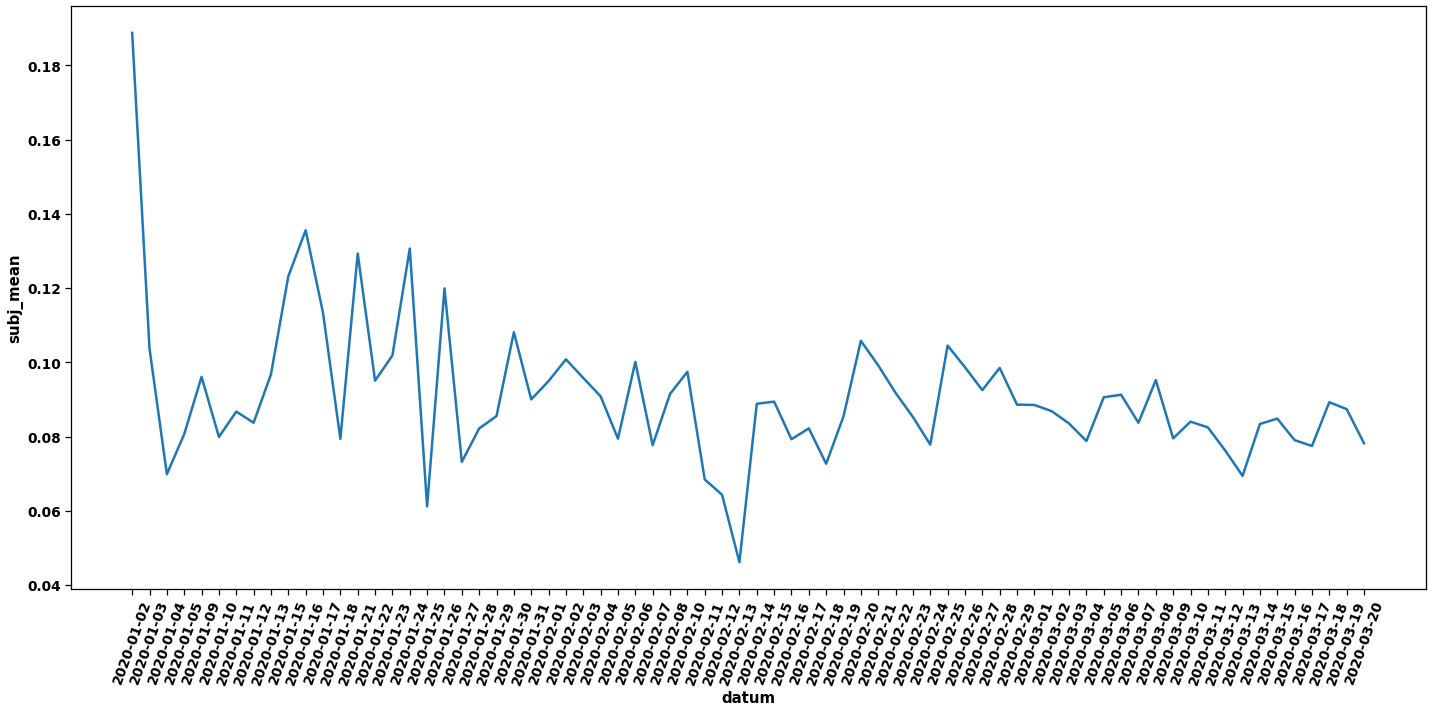

In [239]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

sns.lineplot(x='datum', y='subj_mean', data=subjectivitas)
plt.xticks(rotation=70)
plt.tight_layout()

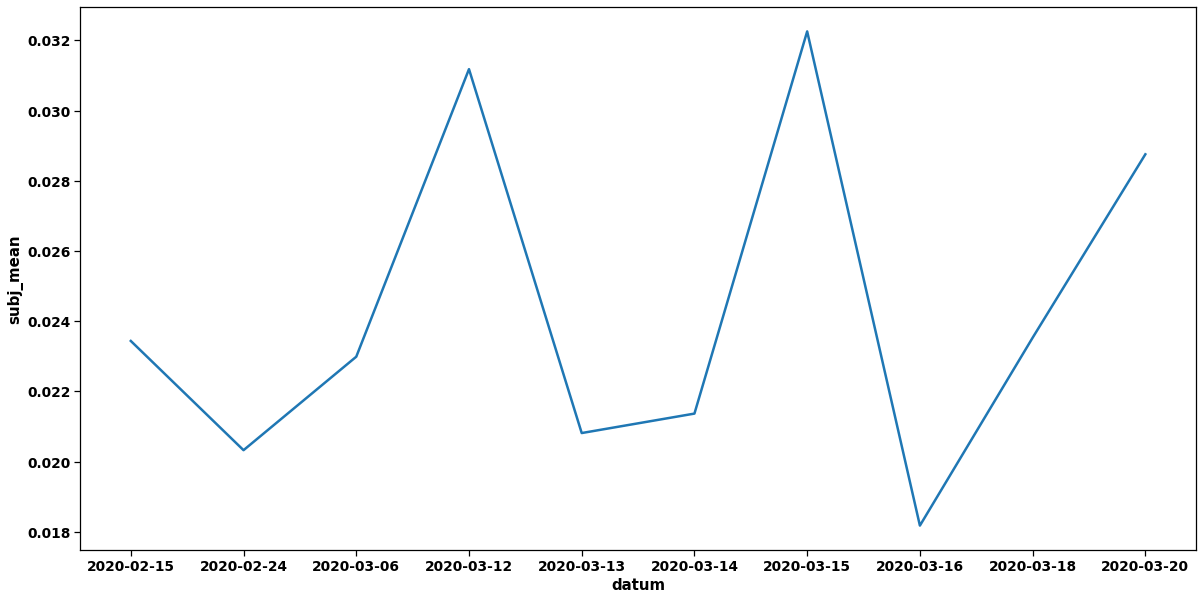

In [242]:
belfold_subj = df_korona[(df_korona['subj_mean'] < 0.035) & df_korona['tag'].str.lower().str.contains('belföld')]
belfold_subj = belfold_subj.groupby(['datum'], as_index=False)['subj_mean'].mean()

sns.lineplot(x='datum', y='subj_mean', data=belfold_subj)

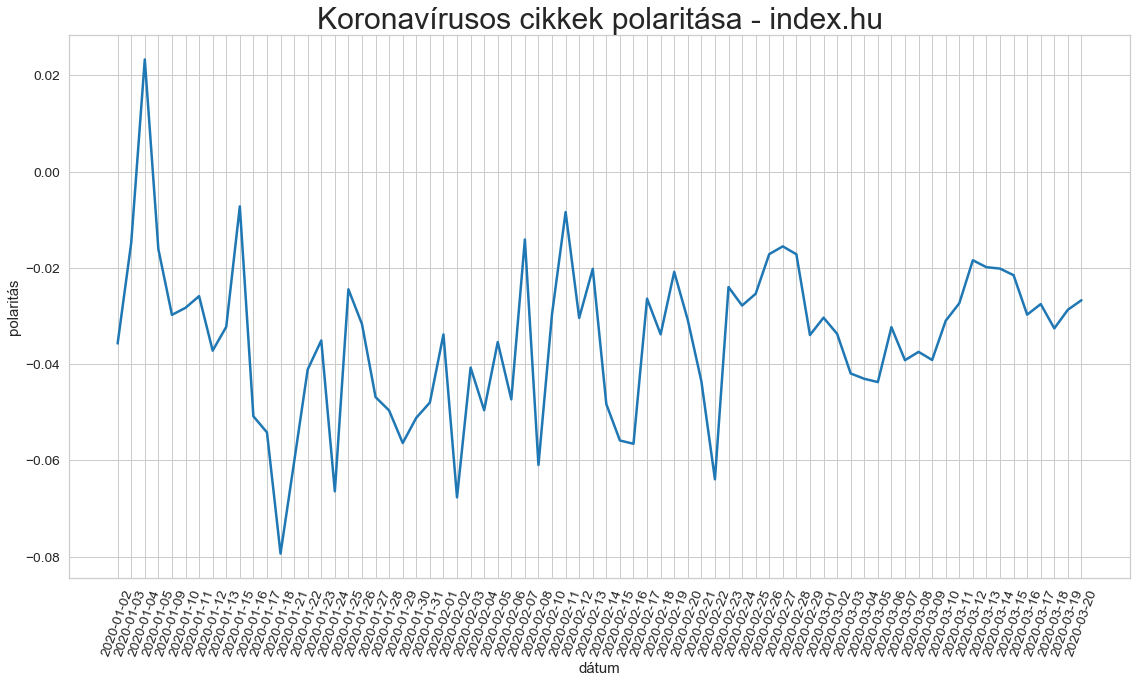

In [245]:
plt.rcParams['figure.figsize'] = [19, 10]


g=sns.lineplot(x="datum", y="senti_pol", data=df_korona, ci=None)

g.set_title("Koronavírusos cikkek polaritása - index.hu", fontsize=30)
g.set_ylabel('polaritás')
g.set_xlabel('dátum')
sns.set_style("whitegrid")

plt.rcParams["axes.labelsize"] = 15
plt.xticks(rotation=70);

In [ ]:
avg = df_korona[['topic', 'month', 'senti_pol']].groupby(['month', 'topic']).mean().reset_index()

In [ ]:
sns.lineplot(x="month", y="senti_pol", hue='topic', data=avg, ci=None)
